In [12]:
%%capture
%run 'BCPM_Implementation.ipynb'

Generates single dimensional data using PG model and performs forward recursion

filtering...


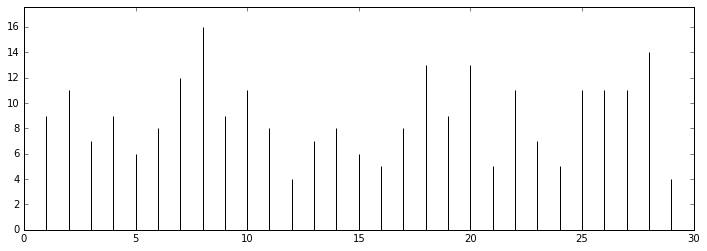

In [13]:
work_dir = '/tmp/toy_example' 
find_or_create(work_dir)

# Generate Model
t = 30
p1 = 0.1
m = 0
n = 1
model = Model.default_model(p1, m, n)
model.prior.a = np.asarray([3])
model.prior.b = np.asarray([2])
model.save(work_dir + '/model.txt')

# Generate Data
data = model.generate_data(t)
data.save(work_dir + '/data')

# Change Point Estimations
print('filtering...')
[result, alpha_predict, alpha] = model.filter(data.v, return_message=True)
result.save(work_dir + '/filtering')

# Visualization
visualize_data(work_dir + '/data', m, n)

Each plot below is a forward message. Each curve in $t$'th plot is a Gamma potential over $h_t$. Remember, forward variables are Gamma mixtures.

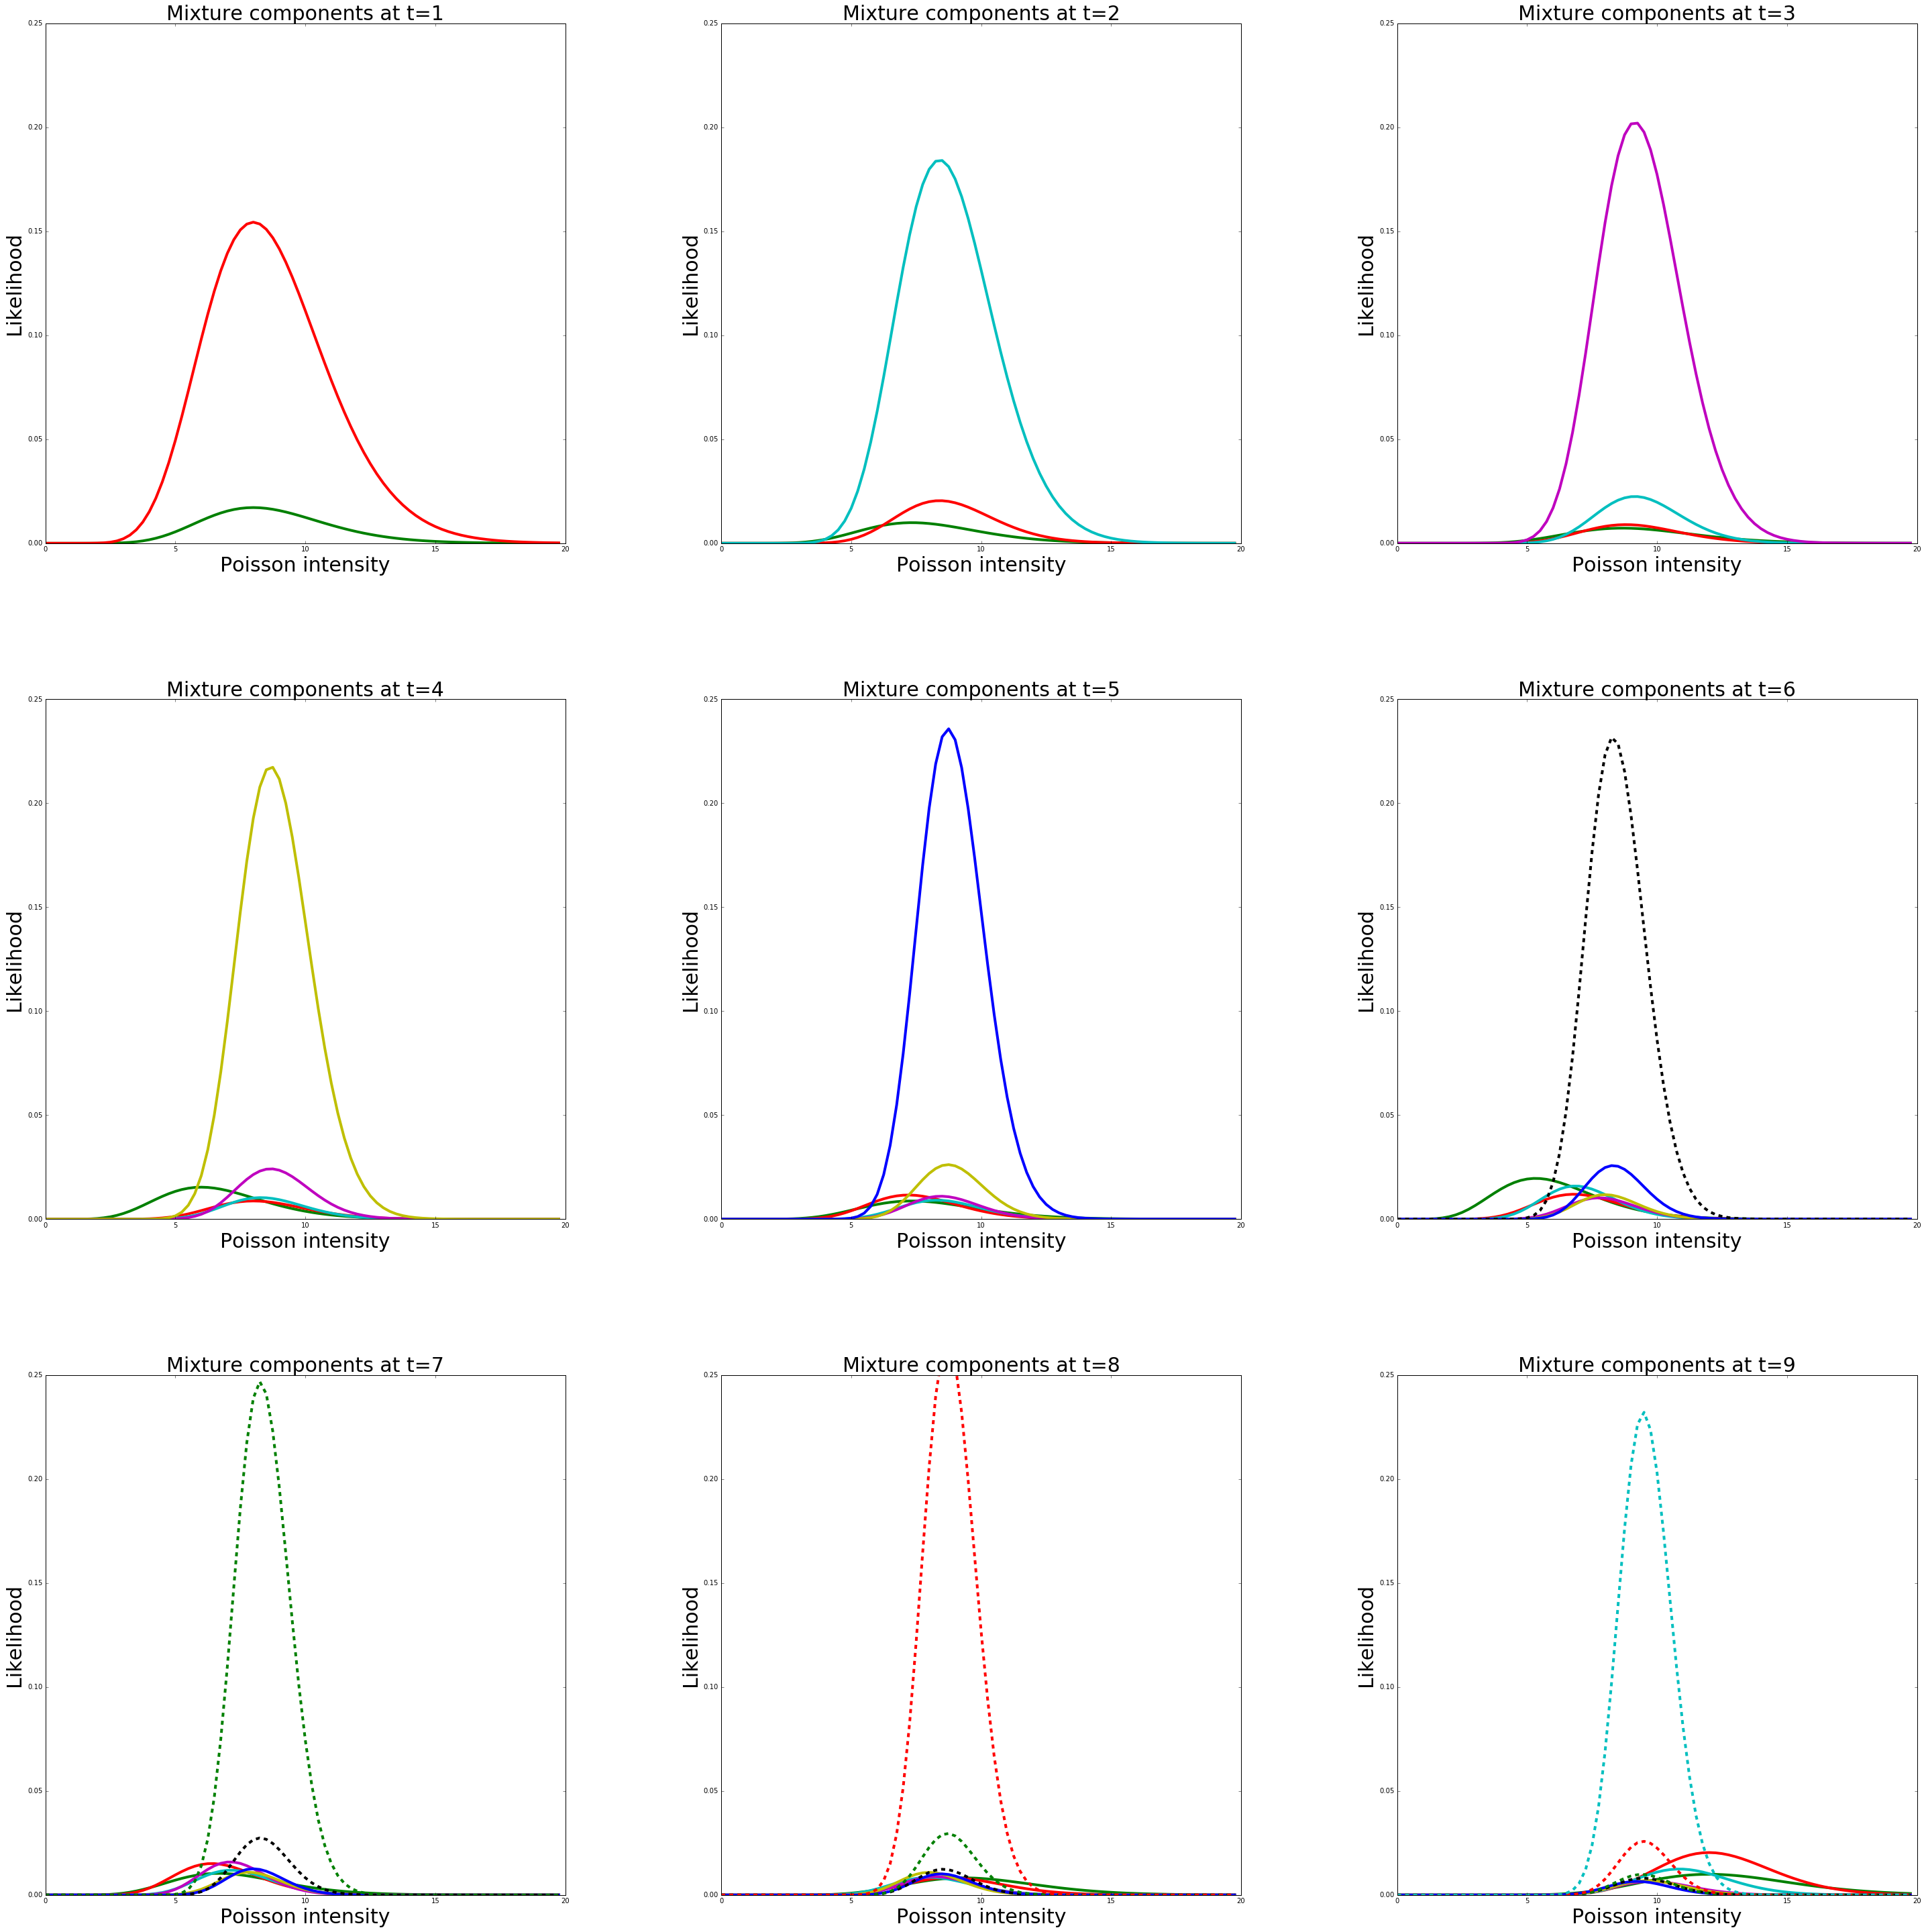

In [14]:
import scipy.stats as ss_

x_ = np.arange(0,20,0.25)
color = ['-g', '-r', '-c', '-m', '-y', '-b', '--k', '--g', '--r', '--c', '--m', '--y', '--b',
         '-g', '-r', '-c', '-m', '-y', '-b', '--k', '--g', '--r', '--c', '--m', '--y', '--b']


def copy_msg(alpha):
    alpha_copy = []
    for mes in alpha:
        mes_copy = Message()
        for comp in mes.potentials:
            mes_copy.potentials.append(comp.copy())
        alpha_copy.append(mes_copy)
    return alpha_copy


def visualize_message_single_plot(msg, t, fontsize_=15):
    norm_consts = msg.pp()
    for j in range(len(msg.potentials)):
        pot = msg.potentials[j]
        lhoods = ss_.gamma.pdf(x_,pot.a[0],scale=pot.b[0])
        plt.plot(x_, norm_consts[j]*lhoods, color[j], linewidth=4)
    plt.title("Mixture components at t="+str(t+1), fontsize=fontsize_)
    plt.xlabel("Poisson intensity", fontsize=fontsize_)
    plt.ylabel("Likelihood", fontsize=fontsize_)
    plt.ylim([0,0.25])
    
    
def visualize_messages_single_plots(alpha, C=5, R=5, W=50, H=50, fontsize_=15, save_=False):
    fig = plt.figure(figsize=(W,H))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
    for i in range(R*C):
        plt.subplot(R,C,i+1)
        visualize_message_single_plot(alpha[i], i, fontsize_)
    if save_:
        plt.savefig("gamma_mixture_components.eps")
    
visualize_messages_single_plots(alpha, C=3, R=3, W=50, H=50, fontsize_=30)

Visualizes each mixture component in a separate plot. What are visualized are as follows:
 - $p(h_0)$, the prior, a single distribution (not a mixture, not a potential)
 - Predict messages (Gamma mixture)
 - Update messages (Gamma mixture)
 - *Unmerged* predict message. In reset models, the components that are reset are simply merged, which reduces the complexity to $O(T^2)$. We visualize the unmerged components in order to show this point.

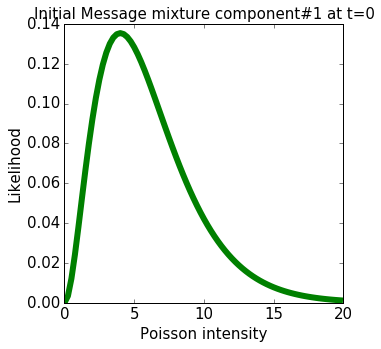

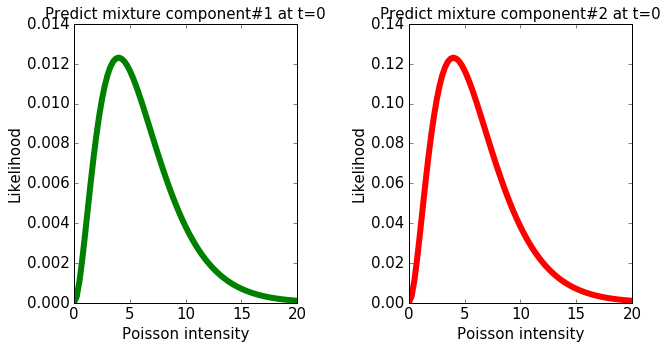

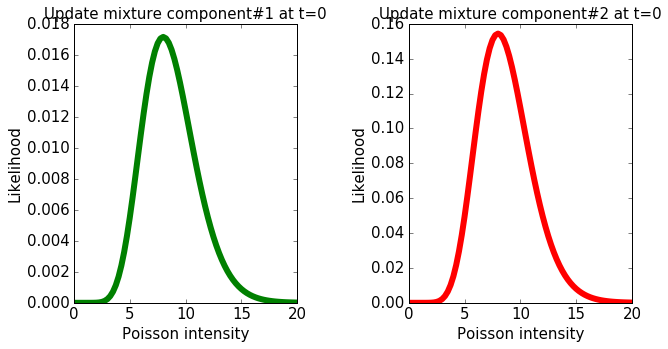

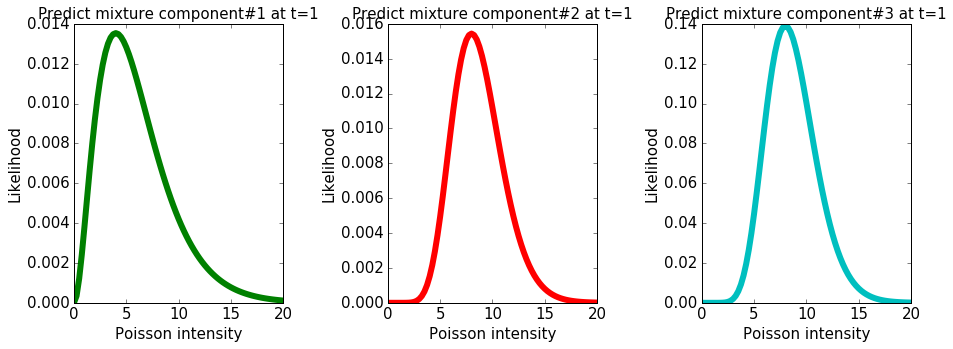

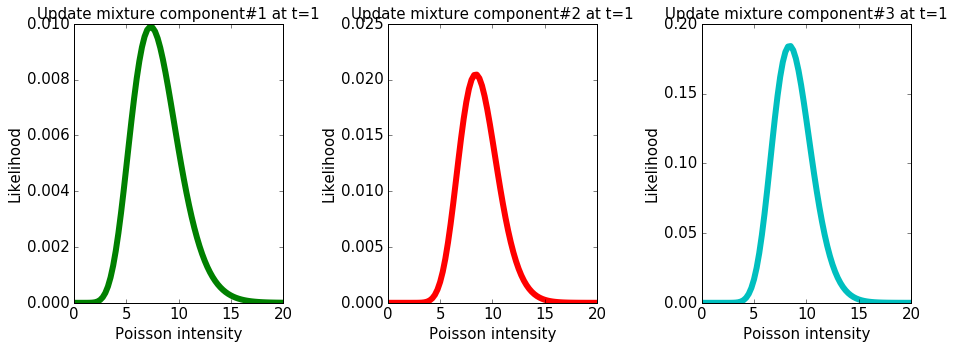

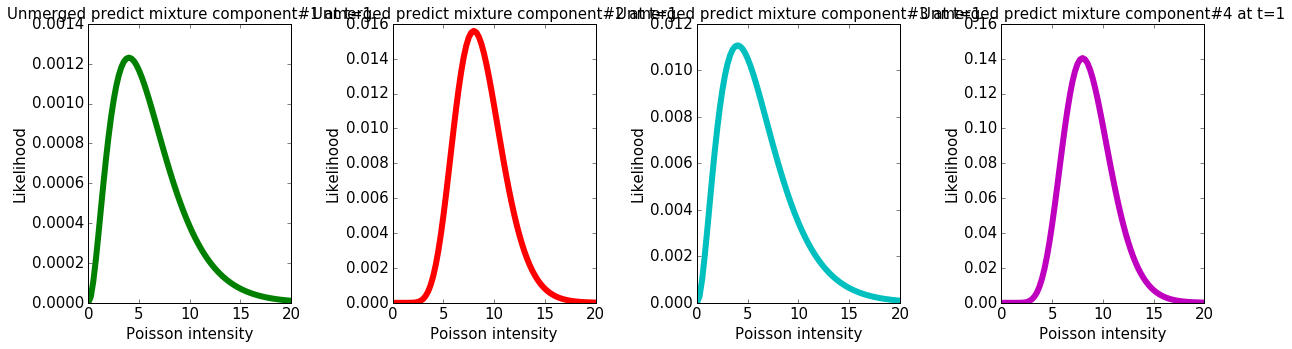

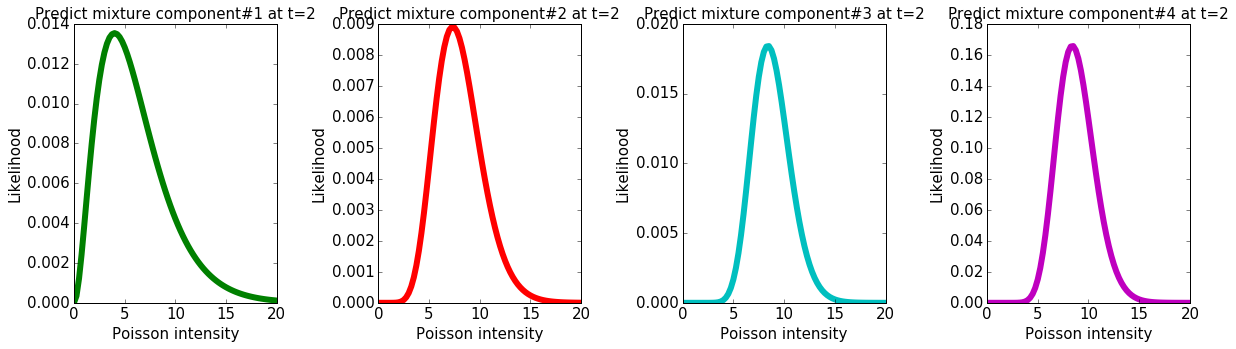

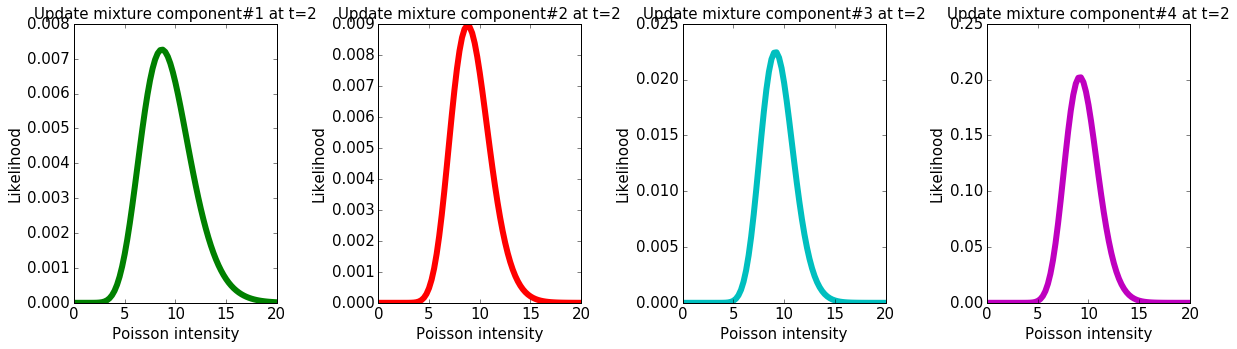

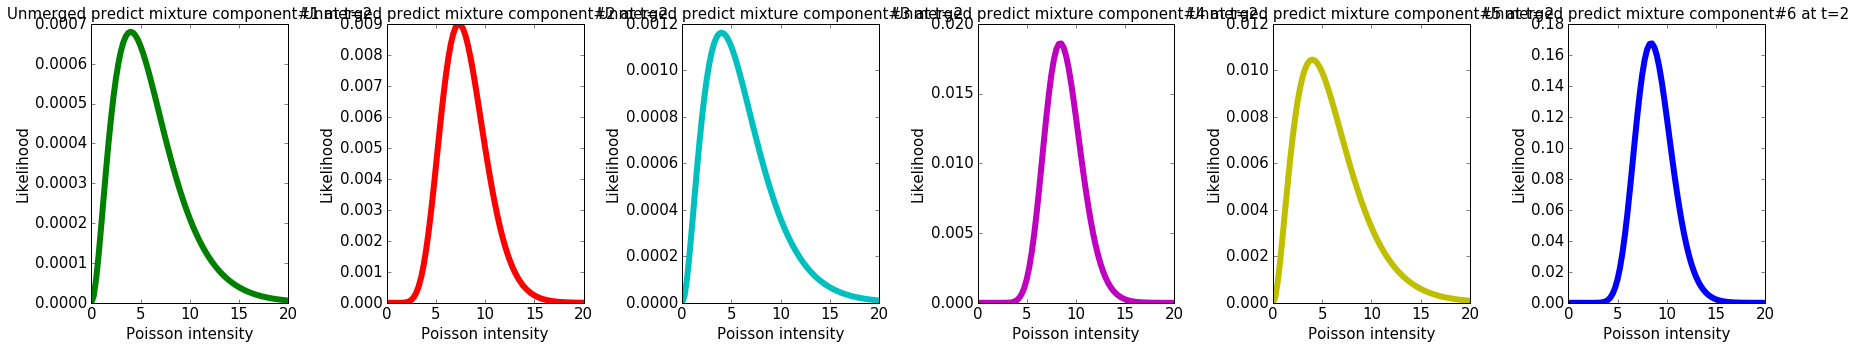

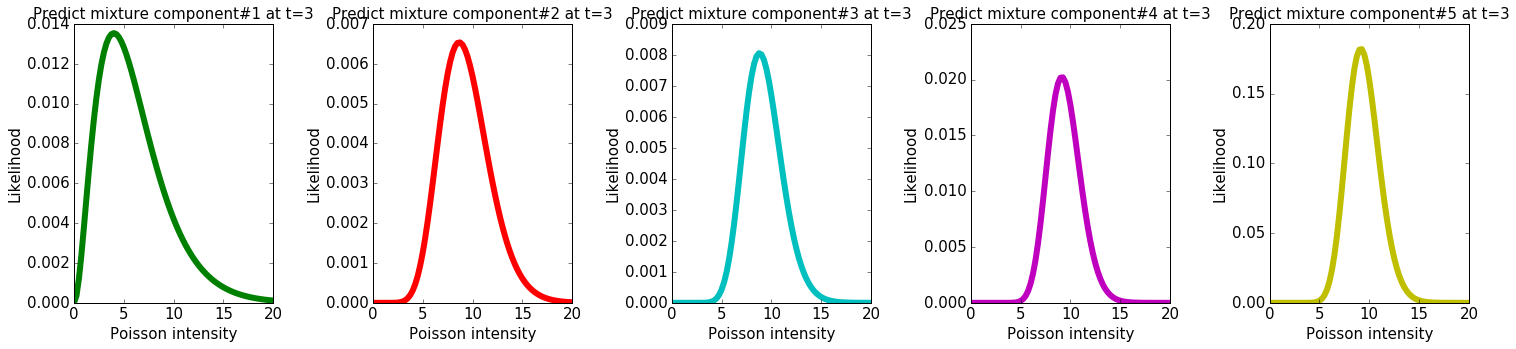

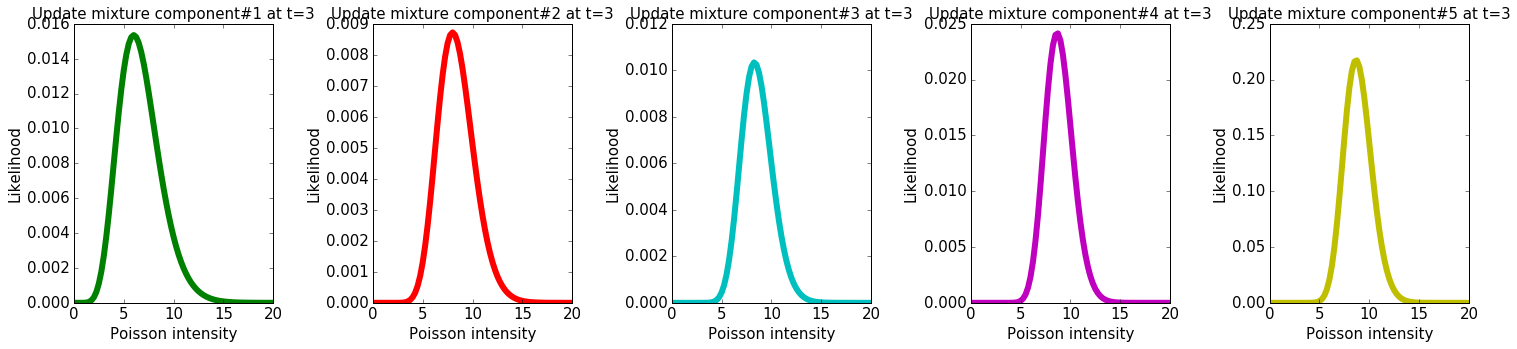

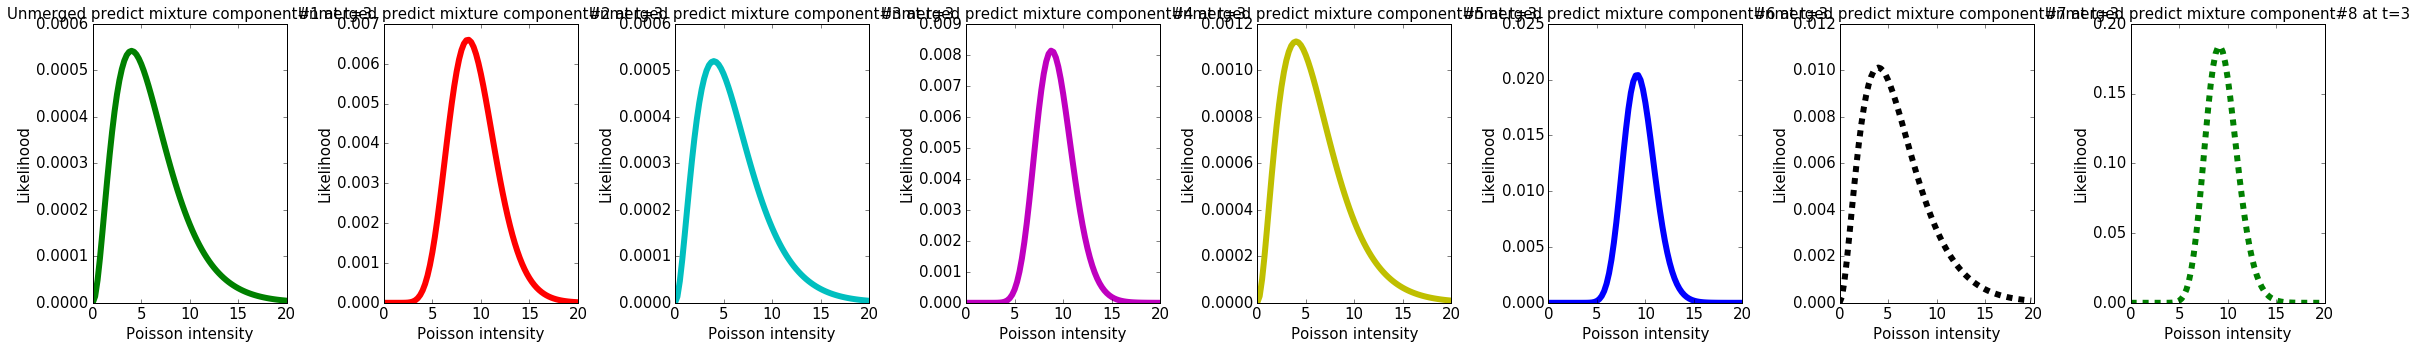

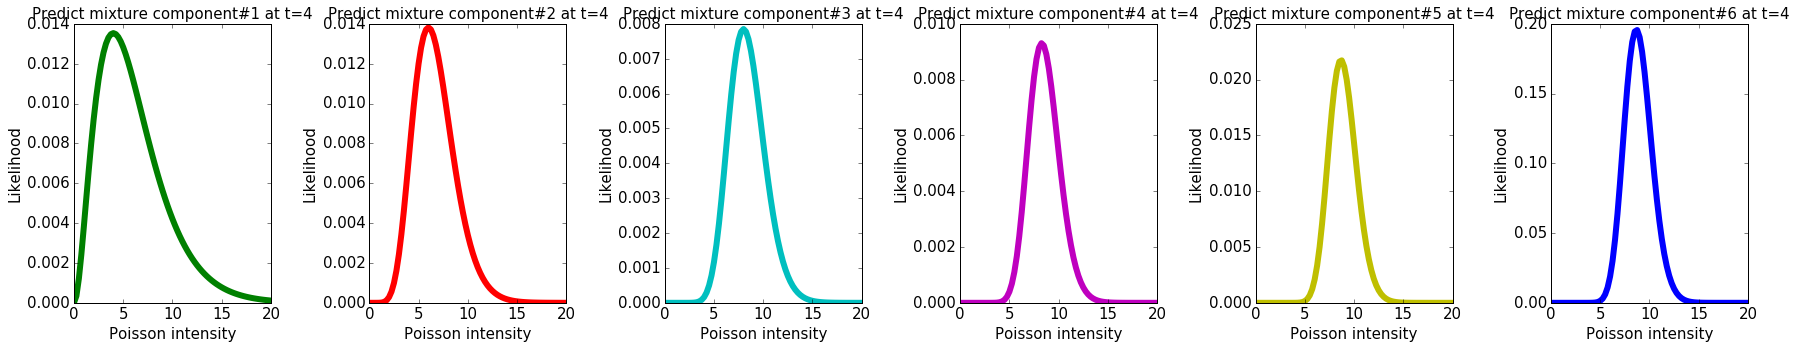

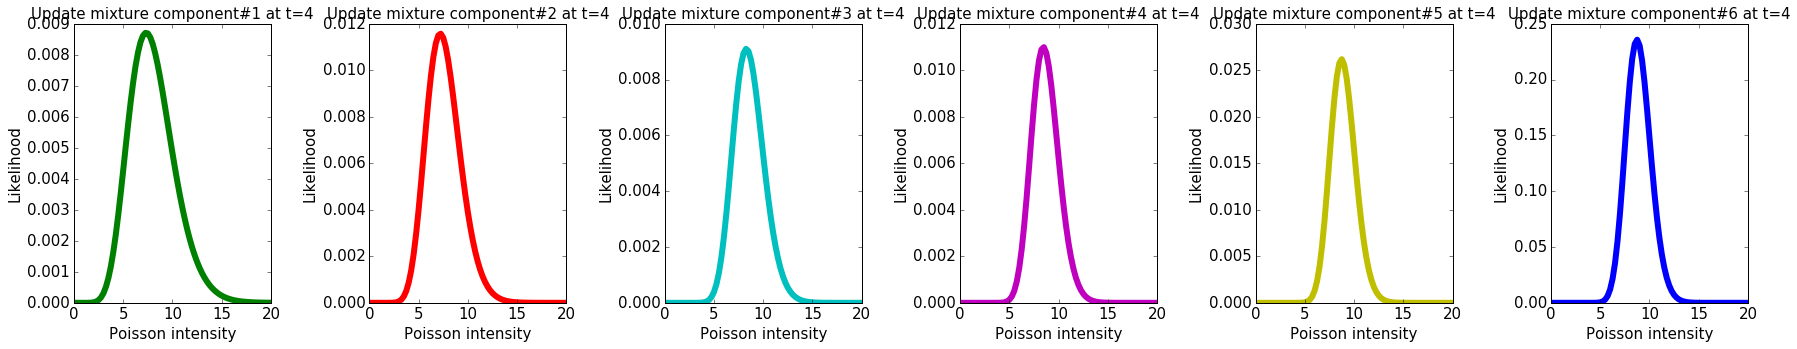

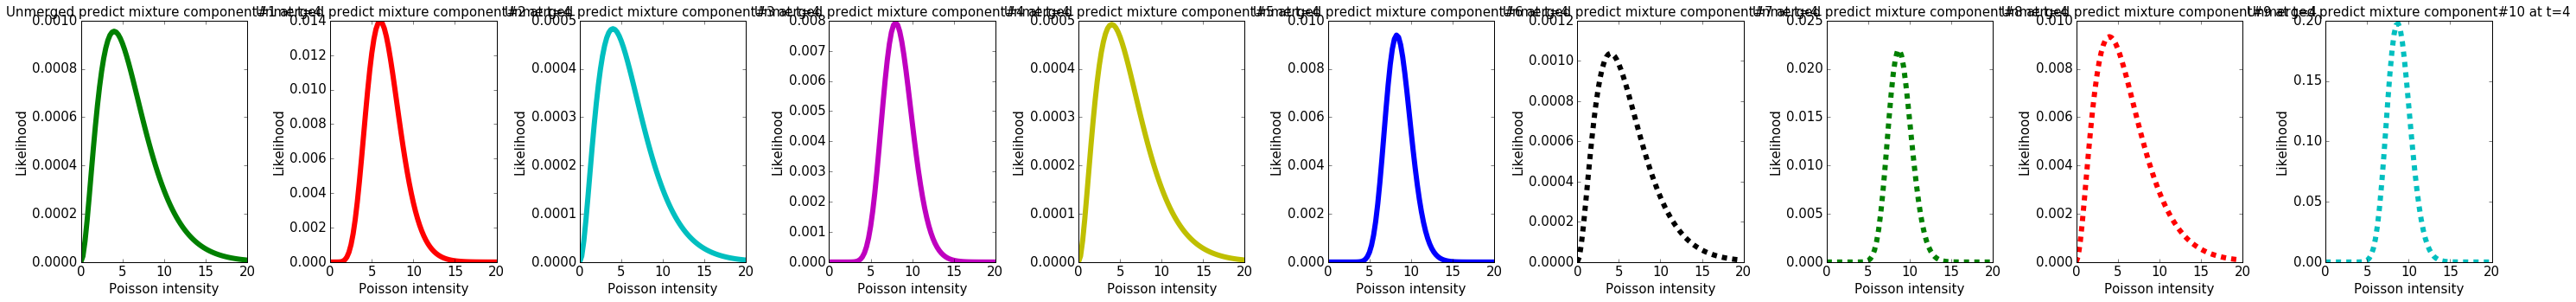

In [15]:
def visualize_message_multiple_plots(msg, t, message_type, fontsize_=15, save_=False):
    NUM_POT = len(msg.potentials)
    fig = plt.figure(figsize=(5*NUM_POT,5))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.1)
    norm_consts = msg.pp()
    for i in range(NUM_POT):
        plt.subplot(1,NUM_POT,i+1)
        pot = msg.potentials[i]
        lhoods = ss_.gamma.pdf(x_,pot.a[0],scale=pot.b[0])
        plt.plot(x_, norm_consts[i]*lhoods, color[i], linewidth=6)
        plt.title(message_type + " mixture component#"+str(i+1) + " at t="+str(t), fontsize=fontsize_)
        plt.xlabel("Poisson intensity", fontsize=fontsize_)
        plt.ylabel("Likelihood", fontsize=fontsize_)
        plt.tick_params(axis='both', which='major', labelsize=15)
    if save_:
        plt.savefig(message_type + "_message_t="+str(t+1)+".eps")
      
    
# visualize p(h_0) first, which is simply a single distribution
alpha_0 = Message()
alpha_0.potentials.append(alpha_predict[0].potentials[1])
alpha_0.potentials[0].log_c = 0
visualize_message_multiple_plots(alpha_0, 0, "Initial Message")

for t in range(5):
    visualize_message_multiple_plots(alpha_predict[t], t, "Predict")
    visualize_message_multiple_plots(alpha[t], t, "Update")
    # build unmerged message
    unmerged_msg = Message()
    if t > 0:
        for i in range(len(alpha[t-1].potentials)):
            p = alpha[t-1].potentials[i]
            change_p = Potential(model.prior.alpha, model.prior.a, model.prior.b, p.log_c+model.log_p1)
            unmerged_msg.potentials.append(change_p)
            unmerged_msg.potentials.append(p)
        visualize_message_multiple_plots(unmerged_msg, t, "Unmerged predict")